# Previsão da série temporal de produção de energia nuclear nos Estados Unidos
#### Modelos utilizados:
- MLP (Um modelo de rede Neural)

## Importando as bibliotecas nescessárias para a atividade

In [12]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler
import warnings

from sklearn.model_selection import TimeSeriesSplit
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.model_selection import learning_curve

from tqdm import tqdm
import itertools

In [13]:
warnings.filterwarnings('ignore')

## Fazendo a carga dos dados e a divisão entre teste, treino e validação

In [14]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("stefancomanita/hourly-electricity-consumption-and-production")

print("Path to dataset files:", path)

Path to dataset files: /home/pierremonteiro/.cache/kagglehub/datasets/stefancomanita/hourly-electricity-consumption-and-production/versions/3


In [15]:
path = path + '/electricityConsumptionAndProductioction.csv'
dados = pd.read_csv(path)

In [16]:
dados

,DateTime,Consumption,Production,Nuclear,Wind,Hydroelectric,Oil and Gas,Coal,Solar,Biomass
0,2019-01-01 00:00:00,6352,6527,1395,79,1383,1896,1744,0,30
1,2019-01-01 01:00:00,6116,5701,1393,96,1112,1429,1641,0,30
2,2019-01-01 02:00:00,5873,5676,1393,142,1030,1465,1616,0,30
3,2019-01-01 03:00:00,5682,5603,1397,191,972,1455,1558,0,30
4,2019-01-01 04:00:00,5557,5454,1393,159,960,1454,1458,0,30
...,...,...,...,...,...,...,...,...,...,...
54165,2025-03-19 19:00:00,8027,6177,1367,593,1922,1217,978,0,71
54166,2025-03-19 20:00:00,7939,6228,1376,647,1920,1223,965,0,71
54167,2025-03-19 21:00:00,7553,6120,1376,671,1881,1171,949,0,69
54168,2025-03-19 22:00:00,6921,6000,1376,730,1827,1130,869,0,69


In [17]:
dados['DateTime'] = pd.to_datetime(dados['DateTime'])
dados = dados.set_index('DateTime')
dados = pd.DataFrame(index=dados.index, data=dados['Nuclear'])

In [18]:
rcParams['figure.figsize'] = 15, 6

<Axes: xlabel='DateTime'>

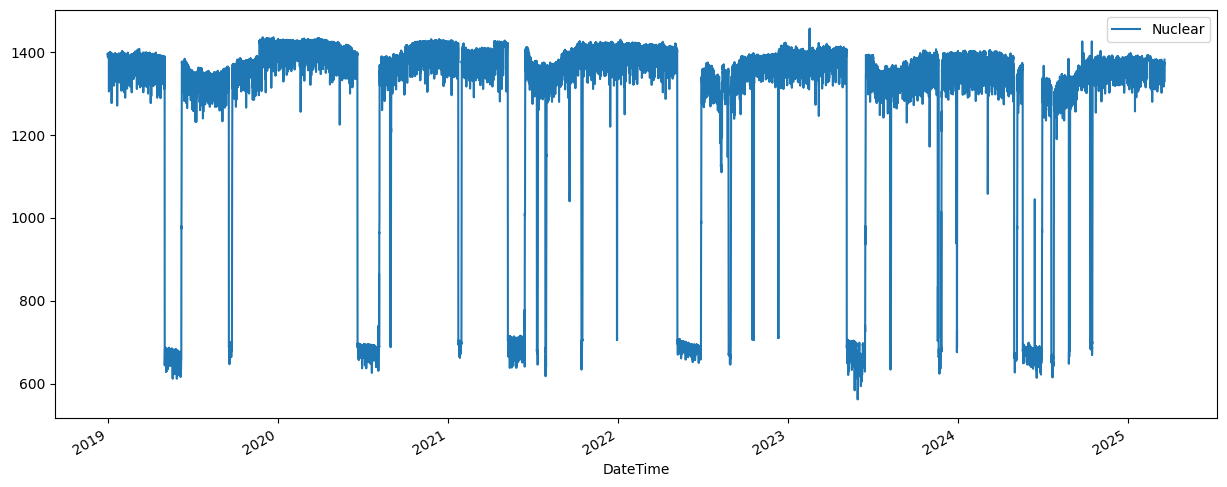

In [19]:
dados.plot()

In [20]:
train = dados.loc['2019': '2021']
val = dados.loc['2022']
test = dados.loc['2023':]

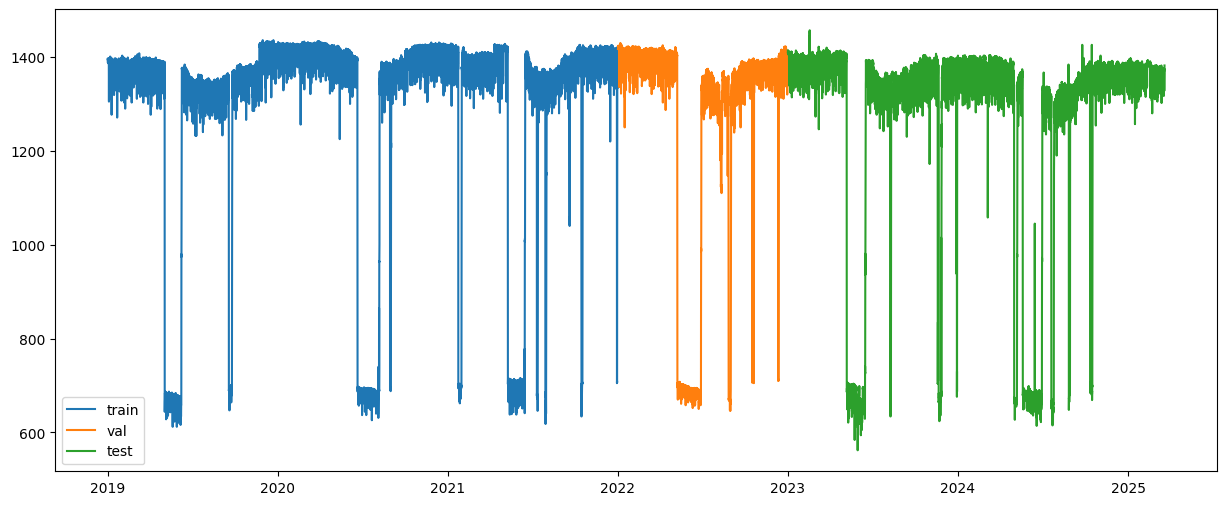

In [21]:
plt.plot(train, label = 'train')
plt.plot(val, label = 'val')
plt.plot(test, label = 'test')
plt.legend(loc = 'best')
plt.show()

### Analise dos dados

Normalização dos dados

In [22]:
scaler = MinMaxScaler()
scaler.fit(train)

X_train_scaler = scaler.transform(train)
X_val_scaler = scaler.transform(val)
X_test_scaler = scaler.transform(test)

In [23]:
def acf_pacf(x, qtd_lag):
    fig = plt.figure(figsize=(16,10))
    ax1 = fig.add_subplot(221)
    fig = sm.graphics.tsa.plot_acf(x, lags=qtd_lag, ax=ax1)
    ax2 = fig.add_subplot(222)
    fig = sm.graphics.tsa.plot_pacf(x, lags=qtd_lag, ax=ax2)
    plt.show()

In [24]:
def create_sliding_windows(series, window_size):

    list_of_sliding_windows = []
    list_size_to_iterate = len(series) - window_size
    for i in range(0, list_size_to_iterate):
        window = series[i: i + window_size + 1]
        list_of_sliding_windows.append(window)

    return np.array(list_of_sliding_windows).reshape(len(list_of_sliding_windows), window_size+1)

avaliar com 5 dias, 10 dias, e com 15 dias - Teste | valor máximo com base no autocorrelação

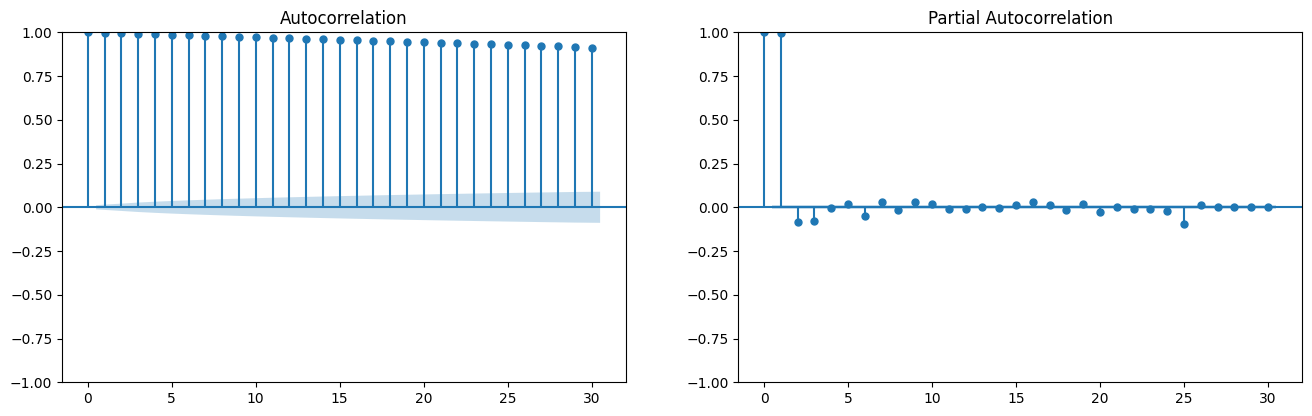

In [25]:
acf_pacf(train.values, 30)

In [26]:
train_windows = create_sliding_windows(X_train_scaler, 24)
val_windows = create_sliding_windows(X_val_scaler, 24)
test_windows = create_sliding_windows(X_test_scaler, 24)

In [27]:
X_train = train_windows[:, 0:-1]
y_train = train_windows[:, -1]

X_val = val_windows[: ,0: -1 ]
y_val = val_windows[: , -1 ]

X_test = test_windows[: ,0: -1 ]
y_test = test_windows[: , -1 ]

In [28]:
X_train_full = np.vstack([X_train, X_val])
y_train_full = np.hstack([y_train, y_val])

##  MLP - Multi-Layer Perceptron
- Rede neural artificial

In [ ]:
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 50), (50, 50, 50)],
    'activation': ['identity', 'logistic','tanh', 'relu'],
    'solver': ['adam', 'lbfgs'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate_init': [0.001, 0.01, 0.1]
}

results = []
best_mse = np.inf

combinacoes = list(itertools.product(
    param_grid['hidden_layer_sizes'],
    param_grid['activation'],
    param_grid['solver'],
    param_grid['alpha'],
    param_grid['learning_rate_init']
))

for hidden_layer_sizes, activation, solver, alpha, learning_rate_init in tqdm(combinacoes, desc="Grid Search"):
    model = MLPRegressor(hidden_layer_sizes=hidden_layer_sizes,
                         activation=activation,
                         solver=solver,
                         alpha=alpha,
                         learning_rate_init=learning_rate_init,
                         random_state=42)

    model.fit(X_train, y_train)

    prev_train = model.predict(X_train)
    prev_val = model.predict(X_val)

    train_error = mean_absolute_percentage_error(y_train, prev_train)
    val_error = mean_absolute_percentage_error(y_val, prev_val)

    if best_mse > val_error:
        results.append({
            'hidden_layer_sizes': hidden_layer_sizes,
            'activation': activation,
            'solver': solver,
            'alpha': alpha,
            'learning_rate_init': learning_rate_init,
            'train_error': train_error,
            'val_error': val_error
        })
        best_mse = val_error

Grid Search:  63%|██████▎   | 228/360 [5:48:24<17:44,  8.06s/it]     

In [ ]:
best_params = min(results, key=lambda x: x['val_error'])

print("Melhores parâmetros encontrados:", best_params)

Melhores parâmetros encontrados: {'hidden_layer_sizes': (100,), 'activation': 'relu', 'solver': 'adam', 'alpha': 0.01, 'learning_rate_init': 0.01, 'train_error': 19619708475.796078, 'val_error': 0.018489691590552707}


In [ ]:
melhor_modelo_mlp = MLPRegressor(hidden_layer_sizes=(50, 50),
                        activation='logistic',
                        solver='lbfgs',
                        alpha=best_params['alpha'],
                        learning_rate_init=best_params['learning_rate_init'],
                        learning_rate = 'adaptive',
                        random_state=42)


melhor_modelo_mlp.fit(X_train_full, y_train_full)

MLPRegressor(activation='logistic', alpha=0.01, hidden_layer_sizes=(50, 50),
             learning_rate='adaptive', learning_rate_init=0.01, random_state=42,
             solver='lbfgs')

In [ ]:
prev_train = melhor_modelo_mlp.predict(X_train_full)

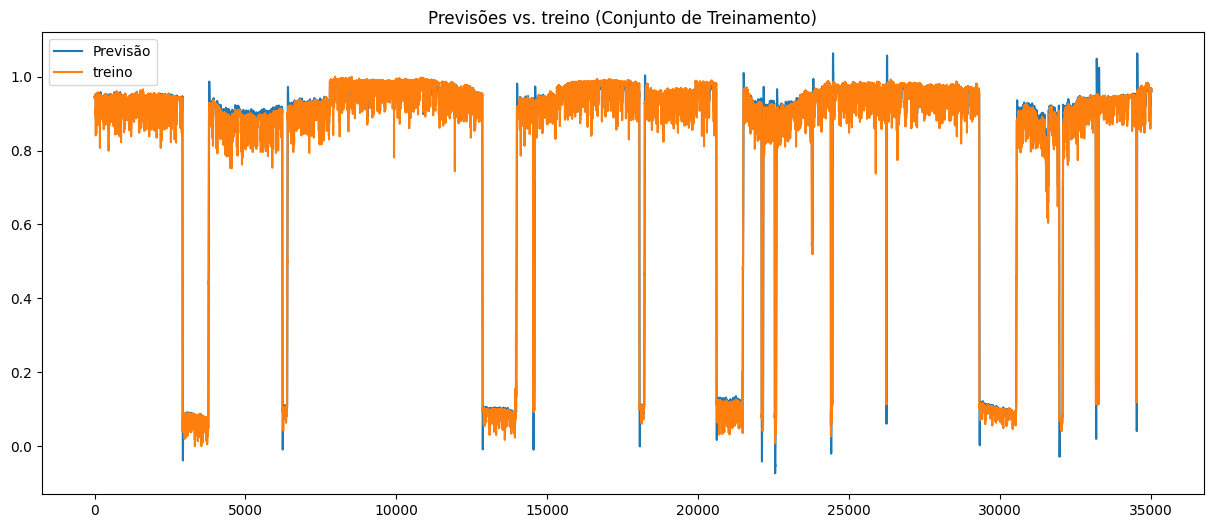

In [ ]:
plt.plot(prev_train, label='Previsão')
plt.plot(y_train_full, label='treino')
plt.legend(loc='best')
plt.title('Previsões vs. treino (Conjunto de Treinamento)')
plt.show()

In [ ]:
rmse_mlp = np.sqrt(mean_squared_error(y_train_full, prev_train))
mse_mlp = mean_squared_error(y_train_full, prev_train)
mape = mean_absolute_percentage_error(prev_train, y_train_full)

print(rmse_mlp)
print(mse_mlp)
print(mape)

0.03841484562759538
0.0014757003645919841
0.11112470685084244


In [ ]:
pred_test = melhor_modelo_mlp.predict(X_test)

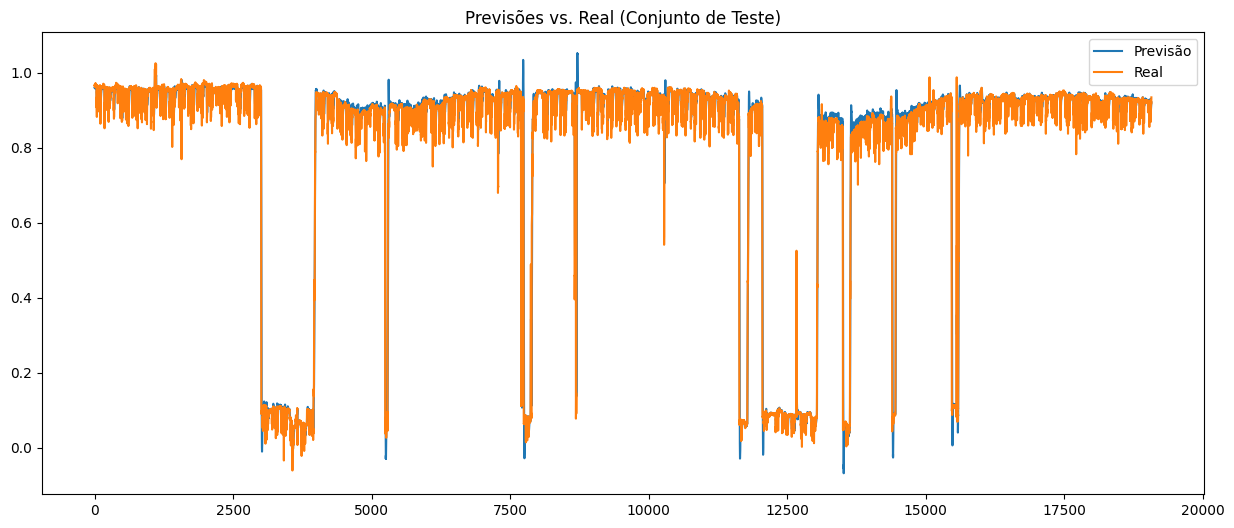

In [ ]:
plt.plot(pred_test, label='Previsão')
plt.plot(y_test, label='Real')
plt.legend(loc='best')
plt.title('Previsões vs. Real (Conjunto de Teste)')
plt.show()

In [ ]:
rmse_test_mlp = np.sqrt(mean_squared_error(y_test, pred_test))
mse_test_mlp = mean_squared_error(y_test, pred_test)
mape_test_mlp = mean_absolute_percentage_error(y_test, pred_test)


print(rmse_test_mlp)
print(mse_test_mlp)
print(mape_test_mlp)

0.043284642116429545
0.0018735602431473861
0.07658422176113822


--- ---

## Comparandos os modelos de teste

In [ ]:
metricas = {
    'Métrica': ['MAPE' ,'mse','RMSE'],
    'Valor': [mape_test_mlp, mse_test_mlp, rmse_test_mlp]
}

pd.DataFrame(metricas)

,Métrica,Valor
0,MAPE,0.076584
1,mse,0.001874
2,RMSE,0.043285


## Curva de aprendizado

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
train_sizes, train_scores, val_scores = learning_curve(
    melhor_modelo_mlp,
    X_train_full,
    y_train_full,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=tscv,
    scoring='r2',
    n_jobs=-1
)

In [ ]:
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
val_mean = np.mean(val_scores, axis=1)
val_std = np.std(val_scores, axis=1)

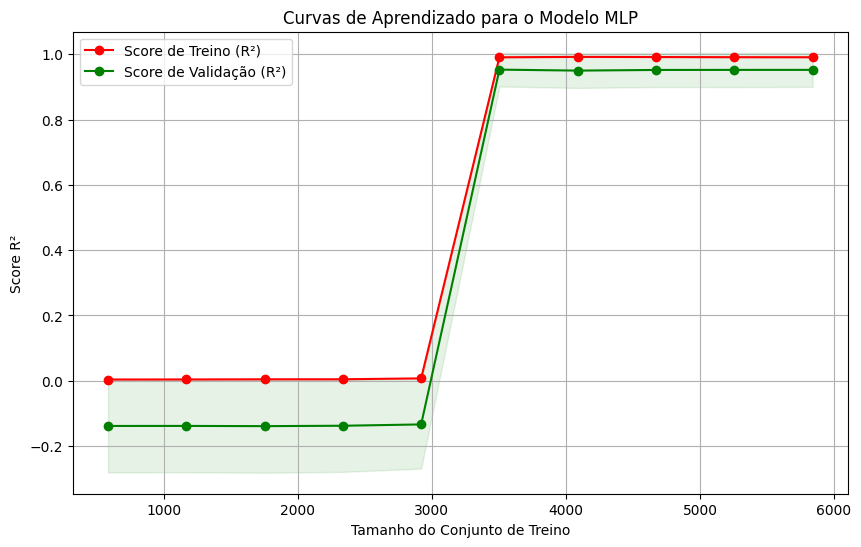

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, 'o-', color='r', label='Score de Treino (R²)')
plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
plt.plot(train_sizes, val_mean, 'o-', color='g', label='Score de Validação (R²)')
plt.fill_between(train_sizes, val_mean - val_std, val_mean + val_std, alpha=0.1, color='g')

plt.xlabel('Tamanho do Conjunto de Treino')
plt.ylabel('Score R²')
plt.title('Curvas de Aprendizado para o Modelo MLP')
plt.legend(loc='best')
plt.grid(True)
plt.show()

### **Célula 3: Processamento e Seleção dos Dados**
**Motivo**: Ajustar o formato dos dados para uma análise de série temporal. A coluna 'DateTime' foi convertida para o formato de data e definida como índice. Em seguida, a análise foi focada selecionando-se apenas a coluna 'Nuclear'.

**Resultado**: O DataFrame foi transformado em uma série temporal univariada contendo apenas os dados de produção de energia nuclear. O gráfico resultante mostra a evolução dessa produção ao longo do tempo.

### **Célula 4: Divisão em Treino, Validação e Teste**
**Motivo**: Segmentar os dados cronologicamente para treinar e avaliar o modelo. O conjunto de treino (`train`) compreende os anos de 2019 a 2021 , o de validação (`val`) corresponde ao ano de 2022, e o de teste (`test`) abrange de 2023 em diante

**Resultado**: Os dados foram divididos em três subconjuntos distintos, visualizados em um gráfico com cores diferentes para cada período.

### **Célula 5: Análise e Preparação Adicional**
**Motivo**: Normalizar os dados para otimizar o treinamento da rede neural e transformá-los em um formato de aprendizado supervisionado.

**Resultado**:
* **Normalização**: Os dados foram escalonados usando `MinMaxScaler`, ajustado apenas com o conjunto de treino. Os conjuntos de treino, validação e teste foram então transformados.
* **Janelas Deslizantes**: Foi definida uma função `create_sliding_windows` para criar janelas de tempo. Essa função foi aplicada para transformar os dados em amostras com 24 passos de tempo como entrada.
* **Features e Alvo**: Os dados das janelas foram divididos em `X` (entradas) e `y` (alvo) para cada conjunto.

### **Célula 6: Grid Search para Hiperparâmetros da MLP**
**Motivo**: Encontrar a melhor combinação de hiperparâmetros para o modelo `MLPRegressor` (uma rede neural artificial). Foi definida uma grade de parâmetros (`param_grid`) para testar diferentes configurações de camadas ocultas, ativação, solver, alfa e taxa de aprendizado.

**Resultado**: Após a busca, os melhores parâmetros encontrados foram uma única camada oculta com 100 neurônios, ativação 'relu', solver 'adam' e alfa de 0.01.

### **Célula 7: Treinamento e Avaliação do Modelo Final**
**Motivo**: Treinar o modelo MLP com os melhores parâmetros encontrados e avaliar seu desempenho. O modelo foi treinado nos dados combinados de treino e validação (`X_train_full`, `y_train_full`).

**Resultado**:
* **Avaliação no Treino**: O modelo mostrou um bom ajuste aos dados de treinamento, com um RMSE de 0.0384 e um MAPE de 0.1111. O gráfico "Previsões vs. treino" ilustra essa aderência.
* **Avaliação no Teste**: No conjunto de teste (dados não vistos), o modelo alcançou um RMSE de 0.0432, MSE de 0.00187 e MAPE de 0.0765. O gráfico "Previsões vs. Real" mostra a capacidade de generalização do modelo.

### **Célula 8: Sumarização das Métricas e Curva de Aprendizado**
**Motivo**: Consolidar as métricas de desempenho do teste e visualizar a curva de aprendizado para diagnosticar o comportamento do modelo.

**Resultado**:
* **Tabela de Métricas**: As métricas de teste (MAPE, mse, RMSE) foram organizadas em um DataFrame para facilitar a visualização.
* **Curva de Aprendizado**: Foi gerada uma curva de aprendizado usando `TimeSeriesSplit` para validação cruzada e `r2` como métrica de pontuação. O gráfico "Curvas de Aprendizado para o Modelo MLP" mostra que tanto o score de treino quanto o de validação convergem para um valor alto (próximo de 1.0), indicando um bom ajuste do modelo.